## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy

def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples
* a validation set containing 50K samples


In [3]:
rand_indices = numpy.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


In [4]:
from keras.layers import Dense, Input
from keras import models
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model
from keras import optimizers
import matplotlib.pyplot as plt

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same.) You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


### 4.1. Build the network

In [8]:
# build the supervised autoencoder network
from keras.layers import Dense, Input, Flatten, Activation, Dropout
from keras import models
from keras.layers.normalization import BatchNormalization

input_img = Input(shape=(784,), name='input_img')

# encoder network
encode1 = Dense(128,activation='relu',name='encode1')(input_img)
encode2=Dense(32,activation='relu',name='encode2')(encode1)
encode3=Dense(8,activation='relu',name='encode3')(encode2)

# The width of the bottleneck layer must be exactly 2.
bottleneck=Dense(4,activation='relu',name='bottleneck')(encode3)

# decoder network
decode1=Dense(8,name='decode1')(bottleneck)
decode2=Dense(32,activation='relu',name='decode2')(decode1)
decode3=Dense(128, activation='relu', name='decode3')(decode2)
decode4=Dense(784, activation='relu', name='decode4')(decode3)

# build a classifier upon the bottleneck layer
classifier1=Dense(32,name='classifier1')(bottleneck)
classifier1=BatchNormalization()(classifier1)
classifier1=Activation('relu')(classifier1)
classifier1=Dropout(0.2)(classifier1)
classifier2=Dense(64,activation='relu',name='classifier2')(classifier1)
classifier2=BatchNormalization()(classifier2)
classifier2=Activation('relu')(classifier2)
classifier2=Dropout(0.5)(classifier2)
classifier3=Dense(10, activation='relu', name='classifier3')(classifier2)
classifier3=BatchNormalization()(classifier3)
classifier3=Activation('softmax')(classifier3)

In [9]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

#sae.summary()

In [10]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [11]:
from keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.7], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 [==============================] - 3s 5ms/step - loss: 1.6022 - decode4_loss: 0.0746 - activation_2_loss: 2.1822 - val_loss: 0.8822 - val_decode4_loss: 0.0603 - val_activation_2_loss: 1.1742
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 0.8500 - decode4_loss: 0.0587 - activation_2_loss: 1.1305 - val_loss: 0.4649 - val_decode4_loss: 0.0570 - val_activation_2_loss: 0.5827
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 0.6297 - decode4_loss: 0.0570 - activation_2_loss: 0.8182 - val_loss: 0.3622 - val_decode4_loss: 0.0552 - val_activation_2_loss: 0.4386
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4999 - decode4_loss: 0.0554 - activation_2_loss: 0.6351 - val_loss: 0.3470 - val_decode4_loss: 0.0550 - val_activation_2_loss: 0.4171
Epoch 5/100
313/313 [==============================] - 1s 4ms/step - loss: 0.4575 - decode4_loss: 0.0546 - activation_2_loss: 0.5756 - val_loss: 0.3034 - va

Epoch 40/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1654 - decode4_loss: 0.0490 - activation_2_loss: 0.1662 - val_loss: 0.2612 - val_decode4_loss: 0.0489 - val_activation_2_loss: 0.3033
Epoch 41/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1761 - decode4_loss: 0.0491 - activation_2_loss: 0.1813 - val_loss: 0.2653 - val_decode4_loss: 0.0490 - val_activation_2_loss: 0.3091
Epoch 42/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1725 - decode4_loss: 0.0485 - activation_2_loss: 0.1771 - val_loss: 0.2603 - val_decode4_loss: 0.0485 - val_activation_2_loss: 0.3025
Epoch 43/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1704 - decode4_loss: 0.0485 - activation_2_loss: 0.1741 - val_loss: 0.2723 - val_decode4_loss: 0.0489 - val_activation_2_loss: 0.3192
Epoch 44/100
313/313 [==============================] - 1s 5ms/step - loss: 0.1457 - decode4_loss: 0.0485 - activation_2_loss: 0.1389 - val_loss: 0.2457

Epoch 79/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1688 - decode4_loss: 0.0480 - activation_2_loss: 0.1725 - val_loss: 0.2975 - val_decode4_loss: 0.0480 - val_activation_2_loss: 0.3564
Epoch 80/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1572 - decode4_loss: 0.0472 - activation_2_loss: 0.1570 - val_loss: 0.3038 - val_decode4_loss: 0.0474 - val_activation_2_loss: 0.3662
Epoch 81/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1765 - decode4_loss: 0.0476 - activation_2_loss: 0.1842 - val_loss: 0.2869 - val_decode4_loss: 0.0470 - val_activation_2_loss: 0.3427
Epoch 82/100
313/313 [==============================] - 2s 5ms/step - loss: 0.1612 - decode4_loss: 0.0476 - activation_2_loss: 0.1623 - val_loss: 0.2920 - val_decode4_loss: 0.0479 - val_activation_2_loss: 0.3487
Epoch 83/100
313/313 [==============================] - 2s 6ms/step - loss: 0.1644 - decode4_loss: 0.0475 - activation_2_loss: 0.1670 - val_loss: 0.2714

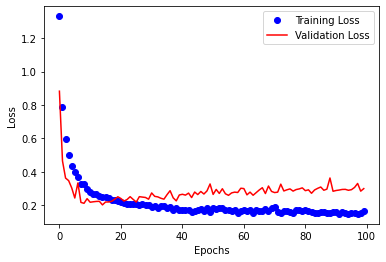

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4.3. Visualize the reconstructed test images

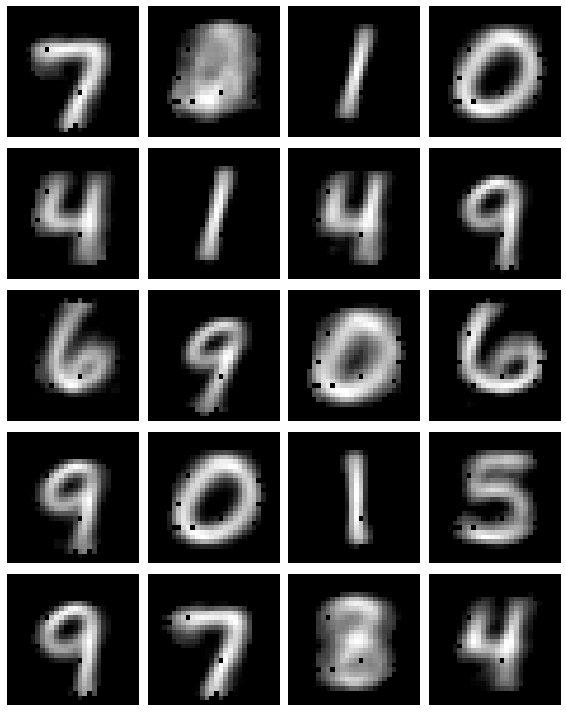

In [13]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()